<a href="https://colab.research.google.com/github/abia200304/Distinct-Vehicle-Flow-Prediction-/blob/main/TRIAL2SAELSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
   creating: my_pems_data/
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-202

Loading and preprocessing data...
Data shape: (22805, 2)
Data loaded successfully!
Training samples: 15497
Validation samples: 2735
Test samples: 4558

Training sparse autoencoder...
Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - loss: 2.9797 - mae: 0.6163 - val_loss: 0.5882 - val_mae: 0.1950 - learning_rate: 0.0010
Epoch 2/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - loss: 0.4283 - mae: 0.2078 - val_loss: 0.1299 - val_mae: 0.1915 - learning_rate: 0.0010
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0632 - mae: 0.0882 - val_loss: 0.0512 - val_mae: 0.1550 - learning_rate: 0.0010
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - loss: 0.0215 - mae: 0.0824 - val_loss: 0.0213 - val_mae: 0.0862 - learning_rate: 0.0010
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - loss: 0.0152 - mae: 0.0816 - val_loss: 0.0161 - val_mae: 0.0623 - learning_rate: 0.0010
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0135 - mae: 0.0795 - val_loss: 0.

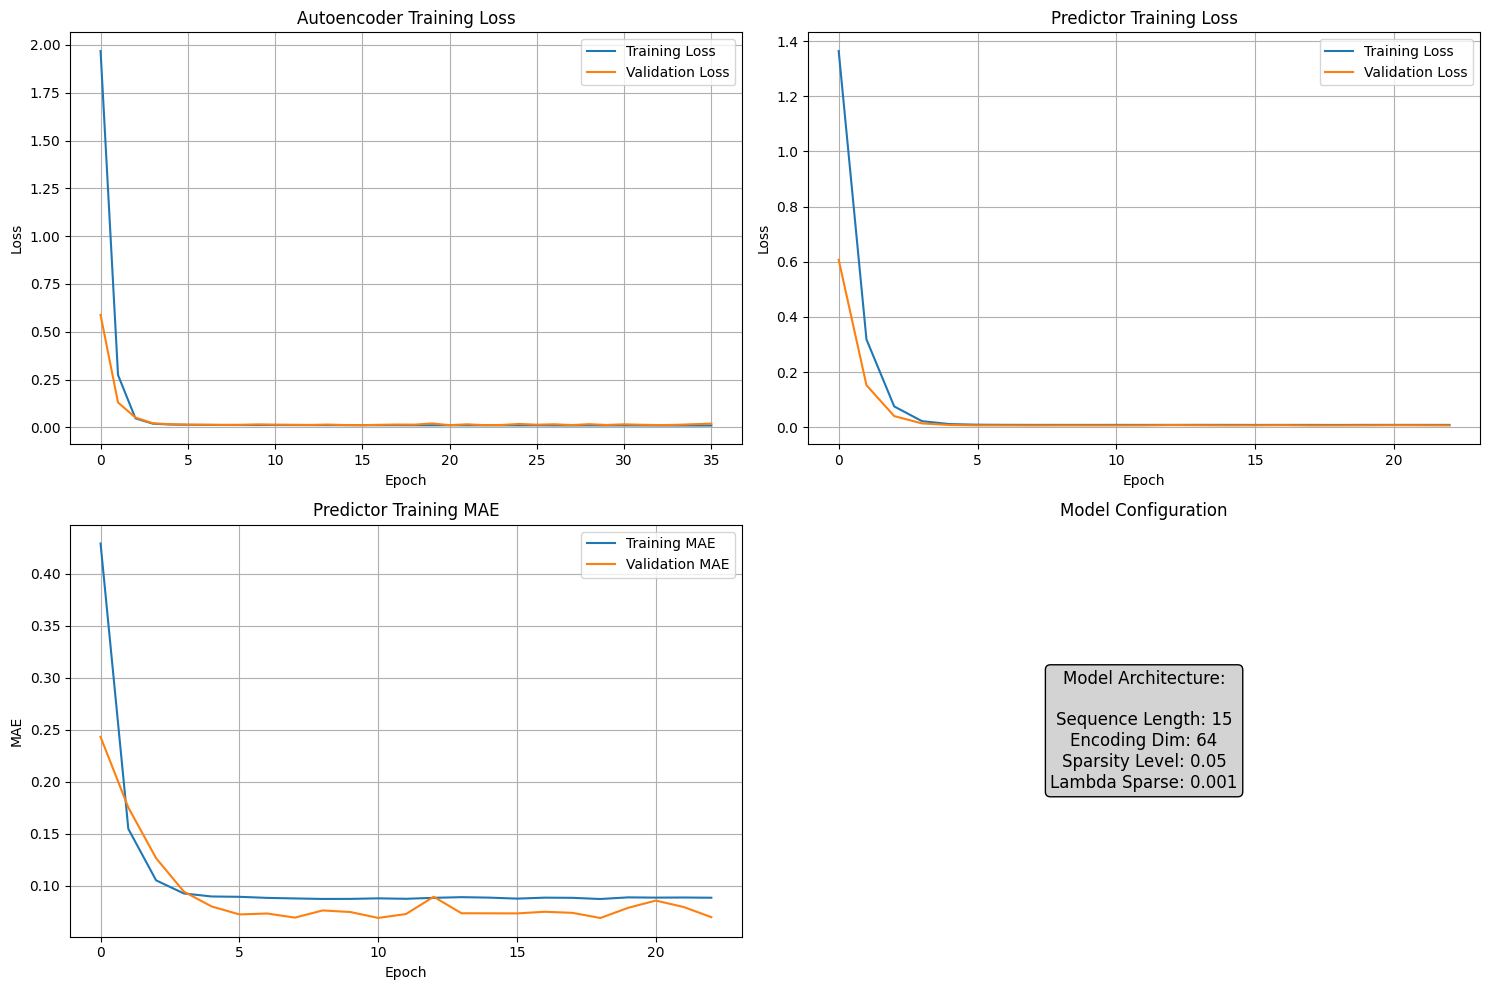

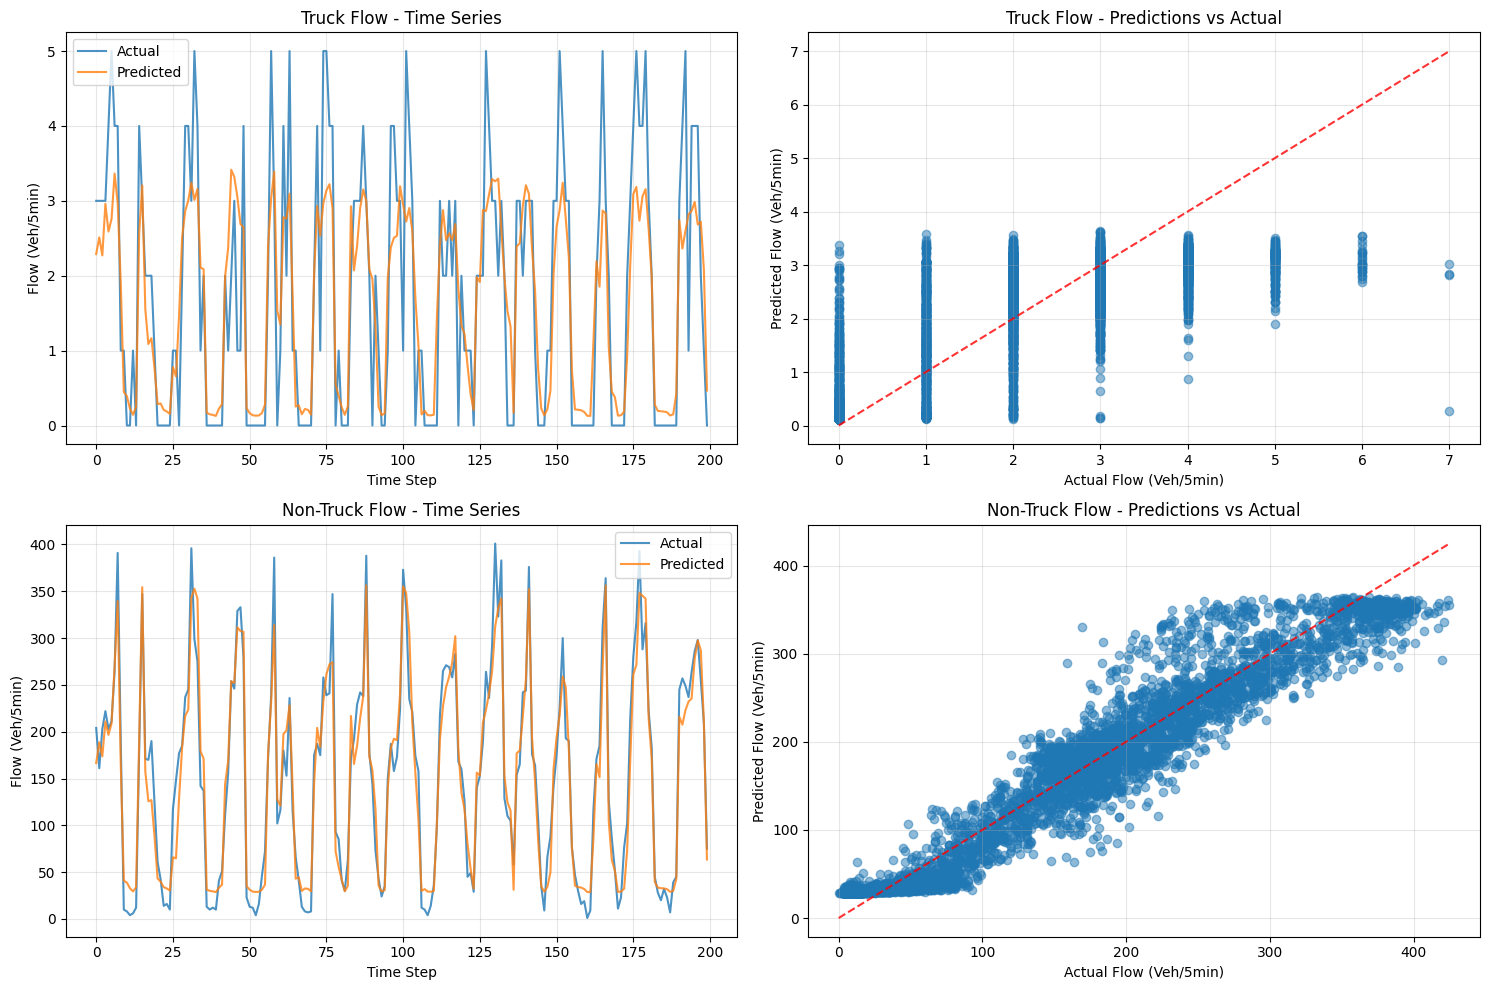

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, BatchNormalization,
                                   Concatenate, GlobalAveragePooling1D, TimeDistributed,
                                   MultiHeadAttention, LayerNormalization, Conv1D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

class ImprovedTrafficFlowModel:
    def __init__(self, sequence_length: int = 15, feature_dim: int = 2,
                 encoding_dim: int = 64, sparsity_level: float = 0.05,
                 lambda_sparse: float = 0.001):
        """
        Improved Traffic Flow Prediction Model with Sparse Autoencoder + Attention

        Args:
            sequence_length: Length of input sequences
            feature_dim: Number of features (truck_flow, non_truck_flow)
            encoding_dim: Dimension of the latent encoding
            sparsity_level: Target sparsity for autoencoder
            lambda_sparse: Weight for sparsity regularization
        """
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.encoding_dim = encoding_dim
        self.sparsity_level = sparsity_level
        self.lambda_sparse = lambda_sparse

        self.scaler = None
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.prediction_model = None
        self.history = {}

    def prepare_data(self, data: np.ndarray, test_size: float = 0.2,
                    val_size: float = 0.15) -> Tuple:
        """
        Prepare time series data for training
        """
        X, y = self._create_sequences(data)

        # Split data chronologically (important for time series)
        n_samples = len(X)
        train_end = int(n_samples * (1 - test_size))
        val_end = int(train_end * (1 - val_size))

        X_train = X[:val_end]
        y_train = y[:val_end]
        X_val = X[val_end:train_end]
        y_val = y[val_end:train_end]
        X_test = X[train_end:]
        y_test = y[train_end:]

        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def _create_sequences(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Create sequences for time series prediction"""
        X, y = [], []
        for i in range(len(data) - self.sequence_length):
            X.append(data[i:i + self.sequence_length])
            y.append(data[i + self.sequence_length])
        return np.array(X), np.array(y)

    def _build_improved_autoencoder(self) -> None:
        """Build improved sparse autoencoder with attention mechanism"""

        # Encoder with Conv1D and attention
        encoder_input = Input(shape=(self.sequence_length, self.feature_dim), name='encoder_input')

        # Convolutional layers for feature extraction
        x = Conv1D(16, 3, activation='relu', padding='same')(encoder_input)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

        x = Conv1D(32, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

        # Self-attention layer
        attention_output = MultiHeadAttention(
            num_heads=4,
            key_dim=32,
            dropout=0.1
        )(x, x)

        # Add & Norm
        x = LayerNormalization()(x + attention_output)

        # Global pooling and dense layers
        # x = GlobalAveragePooling1D()(x) # Removed this layer
        x = Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        encoded = layers.LSTM(self.encoding_dim, activation='relu',
                       kernel_regularizer=regularizers.l2(0.01),
                       name='encoded')(x)

        self.encoder = Model(inputs=encoder_input, outputs=encoded, name='encoder')

        # Decoder
        decoder_input = Input(shape=(self.encoding_dim,), name='decoder_input')
        x = Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01))(decoder_input)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Dense(self.sequence_length * self.feature_dim,
                 activation='linear')(x)
        decoded = layers.Reshape((self.sequence_length, self.feature_dim))(x)

        self.decoder = Model(inputs=decoder_input, outputs=decoded, name='decoder')

        # Full autoencoder
        autoencoder_input = Input(shape=(self.sequence_length, self.feature_dim))
        encoded_output = self.encoder(autoencoder_input)
        decoded_output = self.decoder(encoded_output)

        self.autoencoder = Model(inputs=autoencoder_input, outputs=decoded_output,
                                name='sparse_autoencoder')

    def _sparse_loss(self, y_true, y_pred):
        """Improved sparse loss with better numerical stability"""
        # Reconstruction loss
        mse_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))

        # Sparsity loss
        hidden = self.encoder(y_true)
        mean_activation = tf.reduce_mean(hidden, axis=0)

        # Clip to avoid numerical instability
        mean_activation = tf.clip_by_value(mean_activation, 1e-8, 1 - 1e-8)
        sparsity_target = tf.fill(tf.shape(mean_activation), self.sparsity_level)

        # KL divergence for sparsity
        kl_div = tf.reduce_sum(
            self.sparsity_level * tf.math.log(self.sparsity_level / mean_activation) +
            (1 - self.sparsity_level) * tf.math.log((1 - self.sparsity_level) / (1 - mean_activation))
        )

        return mse_loss + self.lambda_sparse * kl_div

    def train_autoencoder(self, X_train: np.ndarray, X_val: np.ndarray,
                         epochs: int = 150, batch_size: int = 32) -> None:
        """Train the sparse autoencoder"""

        if self.autoencoder is None:
            self._build_improved_autoencoder()

        # Compile with advanced optimizer
        optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
        self.autoencoder.compile(optimizer=optimizer, loss=self._sparse_loss,
                               metrics=['mae'])

        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
        )

        # Train
        self.history['autoencoder'] = self.autoencoder.fit(
            X_train, X_train,
            validation_data=(X_val, X_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        print("Autoencoder training completed!")

    def _build_prediction_model(self) -> None:
        """Build improved prediction model using pretrained encoder"""

        if self.encoder is None:
            raise ValueError("Autoencoder must be trained first!")

        # Freeze encoder weights for transfer learning
        for layer in self.encoder.layers:
            layer.trainable = False

        # Input
        input_seq = Input(shape=(self.sequence_length, self.feature_dim))

        # Extract features using pretrained encoder
        encoded_features = self.encoder(input_seq)

        # Additional feature processing
        x = Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01))(encoded_features)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)

        x = Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01))(x)
        x = Dropout(0.2)(x)

        # Output layer
        predictions = Dense(self.feature_dim, activation='linear',
                          name='predictions')(x)

        self.prediction_model = Model(inputs=input_seq, outputs=predictions,
                                    name='traffic_predictor')

    def train_predictor(self, X_train: np.ndarray, y_train: np.ndarray,
                       X_val: np.ndarray, y_val: np.ndarray,
                       epochs: int = 100, batch_size: int = 32) -> None:
        """Train the prediction model"""

        if self.prediction_model is None:
            self._build_prediction_model()

        # Compile
        optimizer = Adam(learning_rate=0.001)
        self.prediction_model.compile(
            optimizer=optimizer,
            loss='huber',  # More robust to outliers than MAE
            metrics=['mae', 'mse']
        )

        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.7, patience=8, min_lr=1e-6
        )

        # Train
        self.history['predictor'] = self.prediction_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        print("Prediction model training completed!")

    def evaluate_model(self, X_test: np.ndarray, y_test: np.ndarray,
                      scaler: Optional[MinMaxScaler] = None) -> dict:
        """Comprehensive model evaluation"""

        predictions = self.prediction_model.predict(X_test)

        # If scaler is provided, inverse transform
        if scaler is not None:
            y_test_orig = scaler.inverse_transform(y_test)
            predictions_orig = scaler.inverse_transform(predictions)
        else:
            y_test_orig = y_test
            predictions_orig = predictions

        # Calculate metrics for each feature
        metrics = {}
        feature_names = ['truck_flow', 'non_truck_flow']
        for i, feature in enumerate(feature_names):
            mask = y_test_orig[:, i] > 1e-8
            if np.any(mask):
                mape_value = np.mean(
                    np.abs((y_test_orig[mask, i] - predictions_orig[mask, i]) /
                           y_test_orig[mask, i])
                ) * 100
            else:
                mape_value = np.nan

            metrics[feature] = {
                'mae': mean_absolute_error(y_test_orig[:, i], predictions_orig[:, i]),
                'mse': mean_squared_error(y_test_orig[:, i], predictions_orig[:, i]),
                'rmse': np.sqrt(mean_squared_error(y_test_orig[:, i], predictions_orig[:, i])),
                'mape': mape_value
            }

        metrics['overall'] = {
            'mae': mean_absolute_error(y_test_orig, predictions_orig),
            'mse': mean_squared_error(y_test_orig, predictions_orig),
            'rmse': np.sqrt(mean_squared_error(y_test_orig, predictions_orig)),
        }

        return metrics, predictions_orig, y_test_orig


    def plot_training_history(self):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Autoencoder loss
        if 'autoencoder' in self.history:
            axes[0, 0].plot(self.history['autoencoder'].history['loss'], label='Training Loss')
            axes[0, 0].plot(self.history['autoencoder'].history['val_loss'], label='Validation Loss')
            axes[0, 0].set_title('Autoencoder Training Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            axes[0, 0].grid(True)

        # Predictor loss
        if 'predictor' in self.history:
            axes[0, 1].plot(self.history['predictor'].history['loss'], label='Training Loss')
            axes[0, 1].plot(self.history['predictor'].history['val_loss'], label='Validation Loss')
            axes[0, 1].set_title('Predictor Training Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True)

        # MAE for predictor
        if 'predictor' in self.history:
            axes[1, 0].plot(self.history['predictor'].history['mae'], label='Training MAE')
            axes[1, 0].plot(self.history['predictor'].history['val_mae'], label='Validation MAE')
            axes[1, 0].set_title('Predictor Training MAE')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('MAE')
            axes[1, 0].legend()
            axes[1, 0].grid(True)

        # Learning rate (if available)
        axes[1, 1].text(0.5, 0.5, 'Model Architecture:\n\n' +
                        f'Sequence Length: {self.sequence_length}\n' +
                        f'Encoding Dim: {self.encoding_dim}\n' +
                        f'Sparsity Level: {self.sparsity_level}\n' +
                        f'Lambda Sparse: {self.lambda_sparse}',
                        transform=axes[1, 1].transAxes, ha='center', va='center',
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1, 1].set_title('Model Configuration')
        axes[1, 1].axis('off')

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, y_true: np.ndarray, y_pred: np.ndarray,
                        n_samples: int = 200):
        """Plot predictions vs actual values"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Limit samples for visualization
        n_samples = min(n_samples, len(y_true))
        idx = np.random.choice(len(y_true), n_samples, replace=False)
        idx = np.sort(idx)

        feature_names = ['Truck Flow', 'Non-Truck Flow']

        for i, feature in enumerate(feature_names):
            # Time series plot
            axes[i, 0].plot(y_true[idx, i], label='Actual', alpha=0.8)
            axes[i, 0].plot(y_pred[idx, i], label='Predicted', alpha=0.8)
            axes[i, 0].set_title(f'{feature} - Time Series')
            axes[i, 0].set_xlabel('Time Step')
            axes[i, 0].set_ylabel('Flow (Veh/5min)')
            axes[i, 0].legend()
            axes[i, 0].grid(True, alpha=0.3)

            # Scatter plot
            axes[i, 1].scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
            min_val = min(y_true[:, i].min(), y_pred[:, i].min())
            max_val = max(y_true[:, i].max(), y_pred[:, i].max())
            axes[i, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
            axes[i, 1].set_title(f'{feature} - Predictions vs Actual')
            axes[i, 1].set_xlabel('Actual Flow (Veh/5min)')
            axes[i, 1].set_ylabel('Predicted Flow (Veh/5min)')
            axes[i, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# Example usage and improvement demonstration
def main():
    """
    Demonstrate the improved model usage
    """
    print("Loading and preprocessing data...")

    # Load your data here
    file_paths = glob('/content/my_pems_data/*.csv')
    if not file_paths:
        raise FileNotFoundError(
            "No CSV files found in /content/my_pems_data/. Please add your traffic data."
        )

    all_data = []
    for file in file_paths:
        df_temp = pd.read_csv(file, delimiter='\t')
        df_temp.columns = df_temp.columns.str.strip()
        all_data.append(df_temp[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])

    combined_df = pd.concat(all_data, ignore_index=True)
    processed_df = combined_df.rename(columns={
        'Flow (Veh/5 Minutes)': 'total_flow',
        'Truck Flow (Veh/5 Minutes)': 'truck_flow'
    })
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']
    processed_df.loc[processed_df['non_truck_flow'] < 0, 'non_truck_flow'] = 0

    # Combine features
    data_unscaled = np.concatenate([
        processed_df['truck_flow'].values.reshape(-1, 1),
        processed_df['non_truck_flow'].values.reshape(-1, 1)
    ], axis=1)

    # Remove outliers (optional)
    Q1 = np.percentile(data_unscaled, 25, axis=0)
    Q3 = np.percentile(data_unscaled, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = np.all((data_unscaled >= lower_bound) & (data_unscaled <= upper_bound), axis=1)
    data_unscaled = data_unscaled[mask]

    # Scale data
    scaler = MinMaxScaler((0, 1))
    data = scaler.fit_transform(data_unscaled)

    print(f"Data shape: {data.shape}")
    print("Data loaded successfully!")

    # Initialize improved model
    model = ImprovedTrafficFlowModel(
        sequence_length=15,
        feature_dim=2,
        encoding_dim=64,
        sparsity_level=0.05,
        lambda_sparse=0.001
    )

    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test = model.prepare_data(data)

    # Train autoencoder
    print("\nTraining sparse autoencoder...")
    model.train_autoencoder(X_train, X_val, epochs=50, batch_size=64)

    # Train predictor
    print("\nTraining prediction model...")
    model.train_predictor(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)

    # Evaluate model
    print("\nEvaluating model...")
    metrics, predictions, y_true = model.evaluate_model(X_test, y_test, scaler)

    # Print results
    print("\n=== MODEL EVALUATION RESULTS ===")
    for feature in ['truck_flow', 'non_truck_flow']:
        print(f"\n{feature.upper()} METRICS:")
        for metric, value in metrics[feature].items():
            print(f"  {metric.upper()}: {value:.4f}")

    print(f"\nOVERALL METRICS:")
    for metric, value in metrics['overall'].items():
        print(f"  {metric.upper()}: {value:.4f}")

    # Plot results
    model.plot_training_history()
    model.plot_predictions(y_true, predictions)

    return model, metrics


if __name__ == "__main__":
    model, metrics = main()

In [ ]:
model.prediction_model.save('SAElstm.keras')
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model.prediction_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save to .tflite file
with open('SAElstm_model_quant.tflite', 'wb') as f:
    f.write(tflite_model)
from google.colab import files

# Download the quantized model
files.download("SAElstm_model_quant.tflite")

Saved artifact at '/tmp/tmpz_7254vf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15, 2), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133709895668112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895669264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895668304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895666768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895666960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895669648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895669456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895670224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895670992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895671184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133709895669072: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>